In [29]:
import pdal
import json
import geopandas as gpd
from shapely.geometry import Polygon, Point
import sys, os
sys.path.append(os.path.abspath(os.path.join('../scripts')))



In [30]:
import json
import pdal
from osgeo import gdal, ogr
import numpy as np
#import rasterio
from glob import glob
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [31]:
DATA_PATH = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/"
PIPELINE_PATH = "get_data.json"

In [32]:
#generating the shapefile
    #code referenced from https://gis.stackexchange.com/questions/268395/converting-raster-tif-to-point-shapefile-using-python
     # The GeoTIFF was first converted into the XYZ format then the .xyz file was renamed to .csv and finally to ESRI Shapefile.
def geo_fetch(bounds:gpd.GeoDataFrame,region:str,data_path:str=DATA_PATH,pipeline_path:str=PIPELINE_PATH):
    boundaries = bounds.to_crs(epsg=3857)
    Xmin,ymin,Xmax,ymax = boundaries.total_bounds
    access_path = data_path + region + "ept.json"
    r = region.strip('/')
    output_laz = "../files/laz/" + r + ".laz"
    output_tif = "../files/tif/" + r + ".tif"
    filename = "../files/shp/" + r
    with open(pipeline_path) as json_file:
        the_json = json.load(json_file)
        the_json['pipeline'][0]['bounds'] = f"([{Xmin},{Xmax}],[{ymin},{ymax}])"
        the_json['pipeline'][0]['filename'] = access_path
        the_json['pipeline'][5]['filename'] = output_laz
        the_json['pipeline'][6]['filename'] = output_tif
    pipeline = pdal.Pipeline(json.dumps(the_json))

    try:
        pipe_exec = pipeline.execute()
        metadata = pipeline.metadata

    except RuntimeError as e:
        print(e)
        print("RunTime Error, writing 0s and moving to next bounds")
        
    #inDs = gdal.Open('{}.tif'.format(filename))
    filename = "../files/shp/" + r
    inDs = gdal.Open(output_tif)
    outDs = gdal.Translate('{}.xyz'.format(filename), inDs, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])
    outDs = None
    try:
        os.remove('{}.csv'.format(filename))
    except OSError:
            pass
    os.rename('{}.xyz'.format(filename), '{}.csv'.format(filename))
    os.system('ogr2ogr -f "ESRI Shapefile" -oo X_POSSIBLE_NAMES=X* -oo Y_POSSIBLE_NAMES=Y* -oo KEEP_GEOM_COLUMNS=NO {0}.shp {0}.csv'.format(filename))
    output_shp = filename + '.shp'

    gdf = gpd.read_file(output_shp)
    gdf.rename(columns={'Z':'elevation'},inplace=True)
    return gdf



In [33]:
def geo_plot(gdf:gpd.GeoDataFrame)->None:
    fig = plt.figure(figsize=(15,6))
    ax = plt.axes(projection='3d')
    ax.scatter3D(gdf.geometry.x, gdf.geometry.y, gdf.elevation, c= gdf.elevation, cmap='terrain')
    ax.set_xlabel("Longitude")
    ax.set_xlabel("Latitude")
    ax.set_zlabel("Elevation")
    plt.savefig("../files/terrain.png")
    plt.show()

In [34]:
MINX, MINY, MAXX, MAXY = [-93.756155, 41.918015, -93.747334, 41.921429]
polygon = Polygon(((MINX, MINY), (MINX, MAXY), (MAXX, MAXY), (MAXX, MINY), (MINX, MINY)))

df = gpd.GeoDataFrame([polygon], columns=["geometry"])
df = df.set_crs(epsg=4326)

In [35]:
#geo_fetch takes 2 inputs in, the a geopandas dataframe containing the bounds the region and outputs a geopandas 
#dataframe with columns elevation 

gdf = geo_fetch(df,"IA_FullState/")
gdf.head()


,elevation,geometry
0,306.51519775390625,POINT (-10436886.930 5149216.890)
1,306.44091796875,POINT (-10436885.930 5149216.890)
2,306.41668701171875,POINT (-10436884.930 5149216.890)
3,306.449859619140625,POINT (-10436883.930 5149216.890)
4,306.4075927734375,POINT (-10436882.930 5149216.890)


In [36]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.plot import show_hist
def plot_raster(self,rast_data, title='', figsize=(10,10)):
        """
        Plots population count in log scale(+1)
        args:
            rast_data (np arrray): an array of the raster image
            title (str): the title of the image
            figsize (tuple): scale of the image to be displayed
        returns:
            pyplot image
        """
        plt.figure(figsize = figsize)
        im1 = plt.imshow(np.log1p(rast_data),) # vmin=0, vmax=2.1)

        plt.title("{}".format(title), fontdict = {'fontsize': 20})  
        plt.axis('off')
        plt.colorbar(im1, fraction=0.03)

In [37]:
def show_raster(path_to_raster):
    """
    displays a raster from a .tif raster file
    args:
        path_to_raster (str): path to the raster file
    returns:
        rasterio image
    """
    src = rasterio.open(path_to_raster)
    fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
    show((src), cmap='Greys_r', contour=True, ax=axrgb)
    show_hist(src, bins=50, histtype='stepfilled',
            lw=0.0, stacked=False, alpha=0.3, ax=axhist)
    plt.show()

In [25]:
#conda install -c conda-forge rasterio

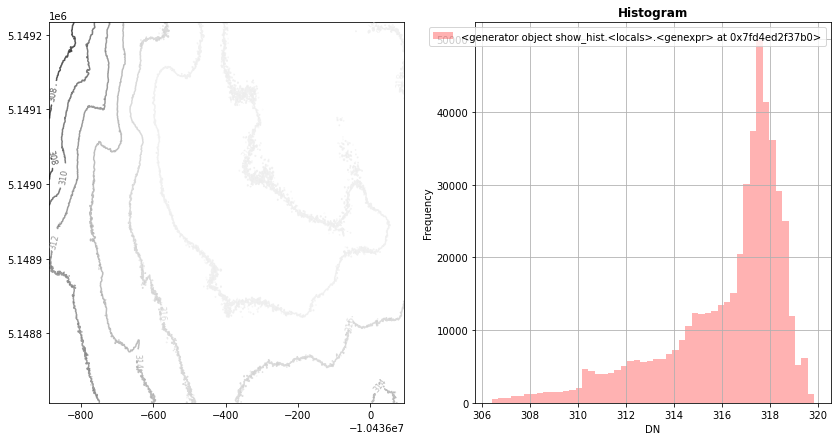

In [38]:
show_raster('../files/tif/IA_FullState.tif')

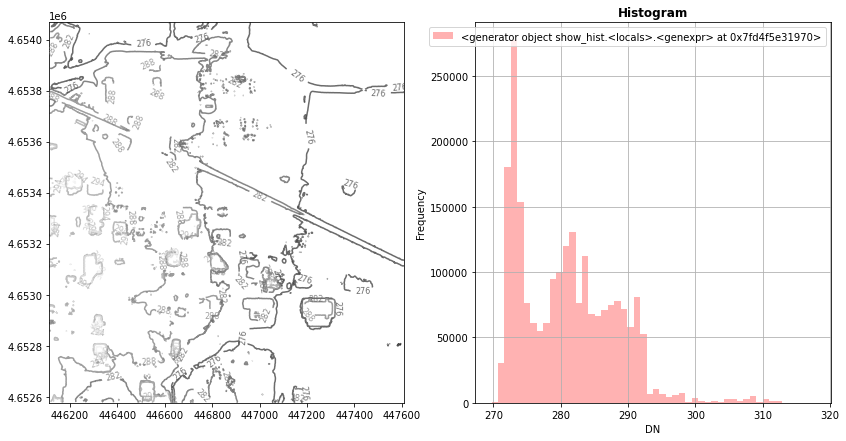

In [27]:
show_raster('../data/iowa.tif')

In [28]:
#geo_plot(gdf)